## Pedestrian detection using open cv
OpenCV has a pretrained HOG(Histogram of Oriented Gradients) + Linear SVM model to detect pedestrians in images and video streams.

In [96]:
!pip install opencv-python imutils

In [97]:
import cv2
import imutils
import matplotlib.pyplot as plt
import numpy as np

In [98]:
font = cv2.FONT_HERSHEY_DUPLEX

# Create a HOGDescriptor object
hog = cv2.HOGDescriptor()
     
# Initialize the People Detector
hog.setSVMDetector(cv2.HOGDescriptor_getDefaultPeopleDetector())    

# Resizing the Image
def detect_image(image):
    # keep a minimum image size for accurate predictions
    image = imutils.resize(image, width=min(400, image.shape[1]))
    
    img_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    rects, weights = hog.detectMultiScale(img_gray, winStride=(2, 2), padding=(10, 10), scale=1.02)
    
    # Drawing the regions in the Image
    for i, (x, y, w, h) in enumerate(rects):
        if weights[i] < 0.13:
            continue
        elif weights[i] < 0.3 and weights[i] > 0.13:
            # cv2.rectangle(image, (x-5, y-10), (x+w, y+h), (0, 0, 255), 2)
            # cv2.putText(image, f'{weights[i]:.3f}',(x, y), font, 0.4, (0, 0, 255),2, cv2.LINE_4)
            continue
        if weights[i] < 0.7 and weights[i] > 0.3:
            cv2.rectangle(image, (x-5, y-10), (x+w, y+h), (50, 122, 255), 2)
            cv2.putText(image, f'{weights[i]:.3f}',(x, y), font, 0.4, (50, 122, 255),2, cv2.LINE_4)
        if weights[i] > 0.7:
            cv2.rectangle(image, (x-5, y-10), (x+w, y+h), (0, 255, 0), 2)
            cv2.putText(image, f'{weights[i]:.3f}',(x, y), font, 0.4, (0, 255, 0),2, cv2.LINE_4)

    return image

# Import the required modules
%pylab inline 
from IPython.display import clear_output

def detect_video(video_in):
    cap = cv2.VideoCapture(video_in)
    
    try:
        while(True):
            # Reading the video stream
            ret, frame = cap.read()
            
            if not ret:
                cap.release()
                break

            frame = detect_image(frame)
            # show video
            # Convert the image from OpenCV BGR format to matplotlib RGB format
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            # Turn off the axis
            axis('off')
            # Title of the window
            title("Detection")
            # Display the frame
            imshow(frame)
            show()
            # Display the frame until new frame is available
            clear_output(wait=True)

    except KeyboardInterrupt:
        # Stop when the video is finished
        cap.release()
        # Message to be displayed after releasing the device
        print("Released Video Resource")

def convert_rgb(image):    
    # this is read in BGR format
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # this converts it into RGB

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


/opt/conda/lib/python3.9/site-packages/IPython/core/magics/pylab.py:162: UserWarning: pylab import has clobbered these variables: ['shuffle', 'random', 'uniform', 'randint', 'triangular', 'seed', 'choice', 'sample']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


##  Legend

- GREEN: High confidence
- ORANGE: Moderate confidence
- RED: Low confidence


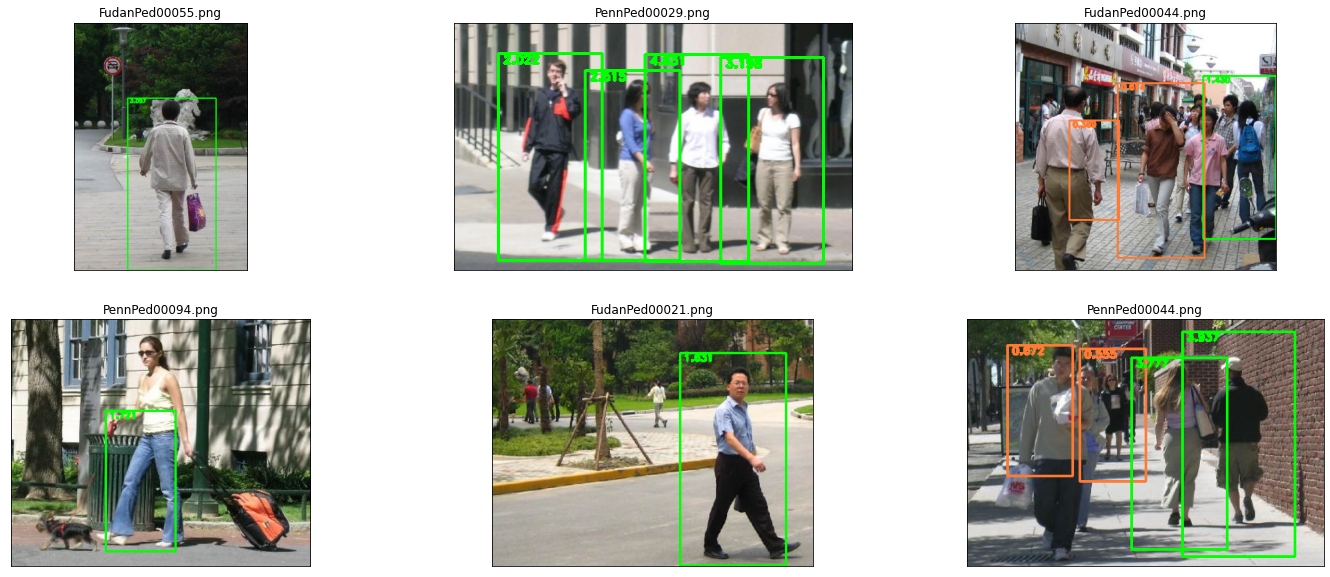

In [99]:
from random import *

amount = 6

fig = plt.figure(figsize=(25, 10)) 

# PedFudan has 00001 - 00096 images
for idx in range(amount):
    
    if idx % 2 == 0:
        # get random number
        rng = randint(1, 74)
        #create file path
        name = f"FudanPed000{rng:02d}.png"
    else:
        # get random number
        rng = randint(1, 96)
        #create file path
        name = f"PennPed000{rng:02d}.png"
    
    path = f"data/PennFudanPed/PNGImages/{name}"
    
    #load image
    image = cv2.imread(path)
    
    if image is not None:
        #detect pedestrians in image
        image_det = detect_image(image)
        #plot
        ax = fig.add_subplot(2, int(amount/2), idx+1, xticks=[], yticks=[]) 
        plt.imshow(convert_rgb(image_det)) #converting to numpy array as plt needs it.
        ax.set_title(name)

In [103]:
video_in = "data/video4.mp4"

detect_video(video_in)

Released Video Resource


## Use yolo detection model

In [101]:
NMS_THRESHOLD=0.3
MIN_CONFIDENCE=0.2

def pedestrian_detection(image, model, layer_name, personidz=0):
    (H, W) = image.shape[:2]
    results = []


    blob = cv2.dnn.blobFromImage(image, 1 / 255.0, (416, 416), swapRB=True, crop=False)
    model.setInput(blob)
    layerOutputs = model.forward(layer_name)

    boxes = []
    centroids = []
    confidences = []

    for output in layerOutputs:
        for detection in output:

            scores = detection[5:]
            classID = np.argmax(scores)
            confidence = scores[classID]

            if classID == personidz and confidence > MIN_CONFIDENCE:

                box = detection[0:4] * np.array([W, H, W, H])
                (centerX, centerY, width, height) = box.astype("int")

                x = int(centerX - (width / 2))
                y = int(centerY - (height / 2))

                boxes.append([x, y, int(width), int(height)])
                centroids.append((centerX, centerY))
                confidences.append(float(confidence))
                
    # apply non-maxima suppression to suppress weak, overlapping
    # bounding boxes
    idzs = cv2.dnn.NMSBoxes(boxes, confidences, MIN_CONFIDENCE, NMS_THRESHOLD)
    # ensure at least one detection exists
    if len(idzs) > 0:
        # loop over the indexes we are keeping
        for i in idzs.flatten():
            # extract the bounding box coordinates
            (x, y) = (boxes[i][0], boxes[i][1])
            (w, h) = (boxes[i][2], boxes[i][3])
            # update our results list to consist of the person
            # prediction probability, bounding box coordinates,
            # and the centroid
            res = (confidences[i], (x, y, x + w, y + h), centroids[i])
            results.append(res)
    # return the list of results
    return results

In [104]:
labelsPath = "yolo-model/coco.names"
LABELS = open(labelsPath).read().strip().split("\n")

weights_path = "yolo-model/yolov4-tiny.weights"
config_path = "yolo-model/yolov4-tiny.cfg"

model = cv2.dnn.readNetFromDarknet(config_path, weights_path)

layer_name = model.getLayerNames()
layer_name = [layer_name[i - 1] for i in model.getUnconnectedOutLayers()]

cap = cv2.VideoCapture("data/video1.mp4")
    
try:
    while(True):
        # Reading the video stream
        ret, frame = cap.read()

        if not ret:
            cap.release()
            break

        image = imutils.resize(frame, width=700)
        results = pedestrian_detection(image, model, layer_name, personidz=LABELS.index("person"))

        for res in results:
            cv2.rectangle(image, (res[1][0],res[1][1]), (res[1][2],res[1][3]), (0, 255, 0), 2)
        
        # show video
        # Convert the image from OpenCV BGR format to matplotlib RGB format
        frame = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # Turn off the axis
        axis('off')
        # Title of the window
        title("Detection")
        # Display the frame
        imshow(frame)
        show()
        # Display the frame until new frame is available
        clear_output(wait=True)

except KeyboardInterrupt:
    # Stop when the video is finished
    cap.release()
    # Message to be displayed after releasing the device
    print("Released Video Resource")

Released Video Resource


In [80]:
!pip install -qr https://raw.githubusercontent.com/ultralytics/yolov5/master/requirements.txt  # install dependencies

In [91]:
!pip3 install torch torchvision --extra-index-url https://download.pytorch.org/whl/cu113

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu113


In [93]:
#import torch

#device = torch.device('cuda:0') if torch.cuda.is_available() else torch.devcie('cpu')

## Model
#model = torch.hub.load('ultralytics/yolov5', 'yolov5s', force_reload=True)
#model.to(device)

# check https://timm.fast.ai/ for model loading